# import packages and functions

In [1]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# # load the landmask
hfac = mygrid['hFacC']
landmsk = hfac[0]
landmsk[np.isnan(landmsk)] = 2
landmsk[landmsk == 1] = np.nan

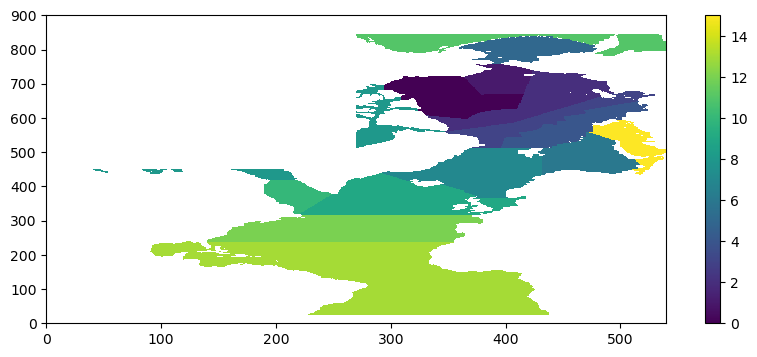

In [3]:
plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0])
plt.colorbar()

In [4]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin ==6)
mymsk[idxs[0],idxs[1]] = 1
mymsk[mymsk == 0] = np.nan

# load the temperature and heat content as a timeseries

In [5]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [32]:
# get the theta and salt for all years

allTHETA = np.full((len(allyears),nz,ny,nx),np.nan)
thetaprofile = np.zeros((nz,15*12))

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    THETA_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        THETA_all[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        hfC[hfC==2] = 1
        THETA[i,:,:,:] = THETA_all[i,:,:,:] * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))  # degC

        # create the thetaprofile
        thetaprofile[:,it] = np.nanmean(THETA[i],axis=(1,2))
        it += 1

    # set this in the larger array
    allTHETA[iy,:,:,:] = np.nanmean(THETA,axis=0) # averaging for the months so we can match Lind
    

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# use this theta to make a mask of the polar front

In [33]:
theta_tomsk = np.nanmean(allTHETA,axis=0)

In [76]:
a = theta_tomsk[0]
b = np.where(a <= 0, a, np.nan)  # Replace non-matching elements with 0
msk_pf = np.where(b <= 0, mymsk, np.nan)

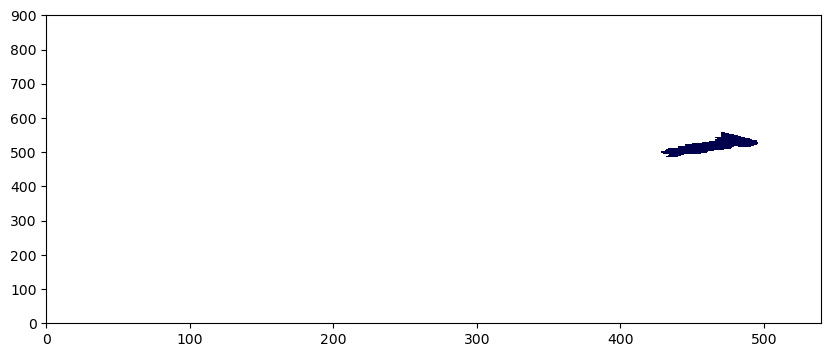

In [77]:
plt.pcolormesh(get_aste_tracer(msk_pf,nfx,nfy)[0],cmap='seismic')

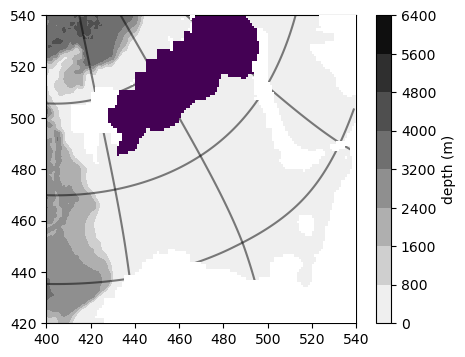

In [78]:
# plot this as a map so we can look at it
fig = plt.figure(figsize=(5,4))
# create the mask based on lat long
lon = mygrid['XC']
lat = mygrid['YC']

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb,label="depth (m)")

plt.pcolormesh(get_aste_tracer(msk_pf,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(hfac,nfx,nfy)[0],zorder=4,cmap="gray_r",vmin=1,vmax=4)

plt.xlim(400,540)
plt.ylim(420,540)

xlims = np.array([420,550])
ylims = np.array([420,560])


CS = plt.contour(get_aste_tracer(lat, nfx, nfy)[0],
                 levels=np.arange(70, 90, 5),
                 colors="black", zorder=1,alpha=0.5)
CS = plt.contour(get_aste_tracer(lon, nfx, nfy)[0],
                 levels=np.arange(0, 90, 20),
                 colors="black", zorder=1,alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)

plt.savefig("figs/mask_Lind_square.png",dpi=300)

# get the upper temperature as a timeseries (figure 1a)

In [79]:
mymsk = msk_pf

In [80]:
# get the theta and salt for all years

allTHETA = np.full((len(allyears),nz,ny,nx),np.nan)
thetaprofile = np.zeros((nz,15*12))

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    THETA_all = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        THETA_all[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        hfC[hfC==2] = 1
        THETA[i,:,:,:] = THETA_all[i,:,:,:] * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))  # degC

        # create the thetaprofile
        thetaprofile[:,it] = np.nanmean(THETA[i],axis=(1,2))
        it += 1

    # set this in the larger array
    allTHETA[iy,:,:,:] = np.nanmean(THETA,axis=0) # averaging for the months so we can match Lind
    

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# get the upper ocn heat content as a timeseries

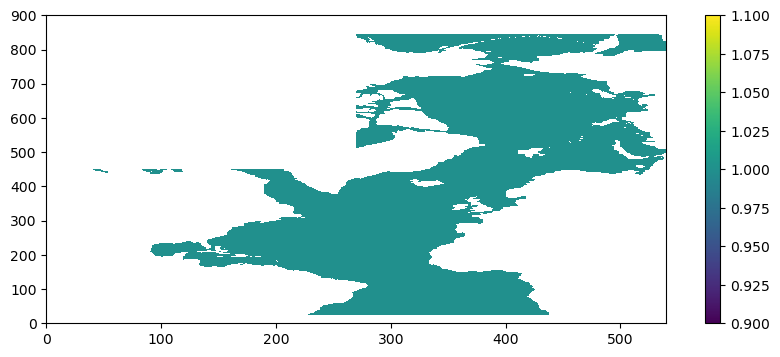

In [83]:
# also plot underneath this the average profiles
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

# # Plot the modified version
plt.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0])
plt.colorbar()
plt.show()
# # plt.pcolormesh(get_aste_tracer(mygrid['hFacC'],nfx,nfy)[0])

In [84]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [171]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10

# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/hfC_modified  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/hfC_modified   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC']#* mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) # * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) #* mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



# do some plots

In [172]:
bounds = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4] # temperature bounds for the colormap
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
len(colors)

12

In [173]:
np.cumsum(mygrid['DRF'][:20])

array([ 10.  ,  20.  ,  30.  ,  40.  ,  50.  ,  60.  ,  70.  ,  80.01,
        90.04, 100.15, 110.47, 121.27, 133.03, 146.45, 162.49, 182.31,
       207.16, 238.26, 276.68, 323.18])

In [174]:
# get annual average of the profile
thetaprofile_reshaped = thetaprofile.reshape(50,15,12)
# thetaprofile_reshaped[20:,:,:] = 0
thetaprofile_avg = np.nanmean(thetaprofile_reshaped, axis=2)  # Shape: (50, 15)
XVc,YVc = np.meshgrid(np.arange(16),mygrid['RF'])


# ID the ArW layer
min_temps = np.nanmin(thetaprofile_avg, axis=0)  # Minimum temperature for each year
min_temp_indices = np.nanargmin(thetaprofile_avg, axis=0)  # Shape: (15,)
min_temp_depths = (YVc[min_temp_indices][:,0] + YVc[min_temp_indices+1][:,0])/2

# ID the AW layer
AWcopy = np.full(thetaprofile_avg.shape,np.nan)
for i in range(len(min_temp_indices)):
    myi = min_temp_indices[i]
    AWcopy[myi:,i] = thetaprofile_avg[myi:,i]
max_temps = np.nanmax(AWcopy,axis=0)
max_temp_indices = np.nanargmax(AWcopy,axis=0)
max_temp_depths = (YVc[max_temp_indices][:,0] + YVc[max_temp_indices+1][:,0])/2

# ID the surface layer, if it exists
surfcopy = np.full(thetaprofile_avg.shape,np.nan)
for i in range(len(min_temp_indices)):
    myi = min_temp_indices[i]
    surfcopy[:myi,i] = thetaprofile_avg[:myi,i]
    
max_temps = np.nanmax(surfcopy,axis=0)
print(max_temps)
max_temp_indices = np.array([])
i = 0
for temp in max_temps:
    if np.isnan(temp):
        max_temp_indices = np.append(max_temp_indices,0)
    else:
        max_temp_indices = np.append(max_temp_indices,int(np.nanargmax(surfcopy[:,i]) ) )
    i += 1

max_temp_indices = max_temp_indices.astype(int)

max_temp_depths_surf = (YVc[max_temp_indices][:,0] + YVc[max_temp_indices+1][:,0])/2

[        nan         nan         nan -0.59891512 -0.68683664         nan
 -0.65114844         nan -0.5119383  -0.24093789 -0.29097347         nan
 -0.79385857 -0.18683927         nan]


In [175]:
# get the midpoint between these two layers
mid_ArW_AW = (min_temp_depths+max_temp_depths)/2
mid_surf_ArW = (max_temp_depths_surf+min_temp_depths)/2

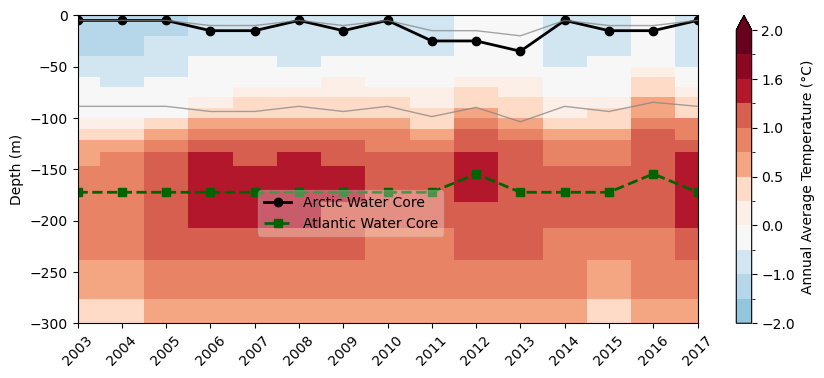

In [176]:
bounds = [-2, -1.5, -1, -0.5, 0, 0.5, 1,  1.4, 1.8, 2.1, 2.3, 2.4, 2.5]
bounds = [-2, -1.7, -1, -0.5, 0, 0.2, 0.5,0.7, 1.0, 1.3, 1.6, 1.9, 2]  # Shifted values

colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

ax = plt.subplot(111)

# make the profiles for each plot, do the total year, ice growth, then ice decline proifile
thetaprofile_reshaped = thetaprofile.reshape(50,15,12)

thetaprofile_avg = np.nanmean(thetaprofile_reshaped, axis=2)  # Shape: (50, 15)
XVc,YVc = np.meshgrid(np.arange(16),mygrid['RF'])

cb = ax.pcolormesh(XVc, YVc, thetaprofile_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
# ax.set_title("Lind region T Profile, Annual Average")
cbar = plt.colorbar(cb,extend="max")
cbar.set_label("Annual Average Temperature (°C)")

xtick_positions = np.arange(0.5, 15.5, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
# ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)


# add the lines
# Overlay lines for key temperature depths
ax.plot(np.arange(0.5,15.5), min_temp_depths, color='black', marker='o', linestyle='-', label="Arctic Water Core",markersize=6,linewidth=2)
ax.plot(np.arange(0.5,15.5), max_temp_depths, color='darkgreen', marker='s', linestyle='--', label="Atlantic Water Core",markersize=6,linewidth=2)

# plot the midpoint lines
ax.plot(np.arange(0.5,15.5), mid_ArW_AW, color='gray', alpha=0.7, linestyle='-',linewidth=1)
ax.plot(np.arange(0.5,15.5), mid_surf_ArW, color='gray', alpha=0.7, linestyle='-',linewidth=1)

plt.xlim(0.5,14.5)
plt.ylabel("Depth (m)")

# ax.legend(loc="lower left", bbox_to_anchor=(0, 0.6), facecolor='white', framealpha=0.3)
ax.legend(loc="lower left", bbox_to_anchor=(0.28, 0.26), facecolor='white', framealpha=0.3)

# plt.savefig("LindFig1c_v2.png",dpi=300)

# make Lind Figure 1

In [177]:
# Create an empty array for edges
edges = np.zeros_like(mymsk)

# Check for edges manually (4-connected neighbors)
for i in range(1, ny-1):  # Ignore borders to prevent index errors
    for j in range(1, nx-1):
        if mymsk[i, j] == 1:  # If mask is 1, check neighbors
            if (
                np.isnan(mymsk[i-1, j]) or  # Top
                np.isnan(mymsk[i+1, j]) or  # Bottom
                np.isnan(mymsk[i, j-1]) or  # Left
                np.isnan(mymsk[i, j+1])     # Right
            ):
                edges[i, j] = 1  # Mark as an edge

In [178]:
# masking
# heat_content = heat_content * np.tile(mymsk[np.newaxis,np.newaxis,:,:],(15,12,1,1))

# heat_content_time = np.nanmean(heat_content,axis=(2,3))
# # fw_content_time = np.nanmean(fw_content,axis=(2,3))

In [187]:
allyears[:5]

array([2003, 2004, 2005, 2006, 2007])

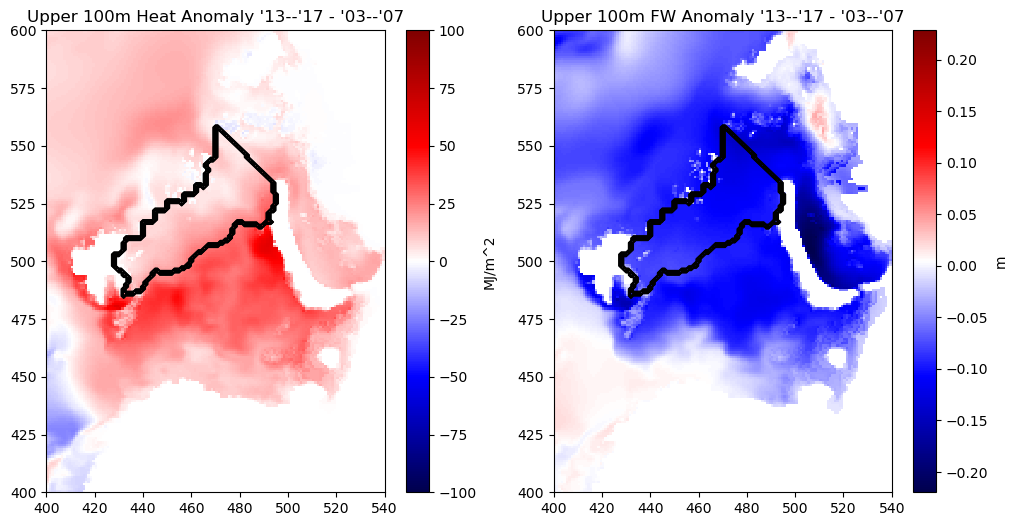

In [189]:
fig = plt.figure(figsize=(12,6))
t2_t = np.nanmean(heat_content[5:],axis=0)
t1_t = np.nanmean(heat_content[:5],axis=0)

name = "'13--'17 - '03--'07"

# first subplot :  upper ocean heat content compare 2016 to 2006
ax = plt.subplot(121)
# data = heat_content[13] - heat_content[2]  
data = t2_t-t1_t
# data = np.nanmean(data,axis=0)  # annual 2016 to 2006 anomaly, MJ/m^2
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=-1e2,vmax=1e2)
ax.contour(get_aste_tracer(edges,nfx,nfy)[0], colors='black', linewidths=1)  # Overlay edges

# add the labels
plt.colorbar(cb,label="MJ/m^2")
ax.set_title("Upper 100m Heat Anomaly "+ name)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(122)
t2_t = np.nanmean(fw_content[5:],axis=0)
t1_t = np.nanmean(fw_content[:5],axis=0)
# data = fw_content[13] - fw_content[2]   
data = t2_t-t1_t
# data = np.nanmean(data,axis=0)  # annual 2016 to 2006 anomaly, MJ/m^2
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic")
ax.contour(get_aste_tracer(edges,nfx,nfy)[0], colors='black', linewidths=1)  # Overlay edges
plt.colorbar(cb,label="m")
ax.set_title("Upper 100m FW Anomaly " + name)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

plt.savefig("anomalies.png",dpi=300)

In [190]:
# Lind goes from 2000-2016 ( we will only use 2006 -- 2016)
x_lind = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(-180,300,192)

slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

x_lind = np.arange(0,15*12)
y_lind = np.linspace(180-250,630-250,15*12)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

2.513089005235602
2.5139664804469275


In [193]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10

# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/hfC_modified  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/hfC_modified   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



In [194]:
# masking
heat_content_time = heat_content * np.tile(mymsk[np.newaxis,np.newaxis,:,:],(15,12,1,1))
heat_content_time = np.nanmean(heat_content_time,axis=(2,3))

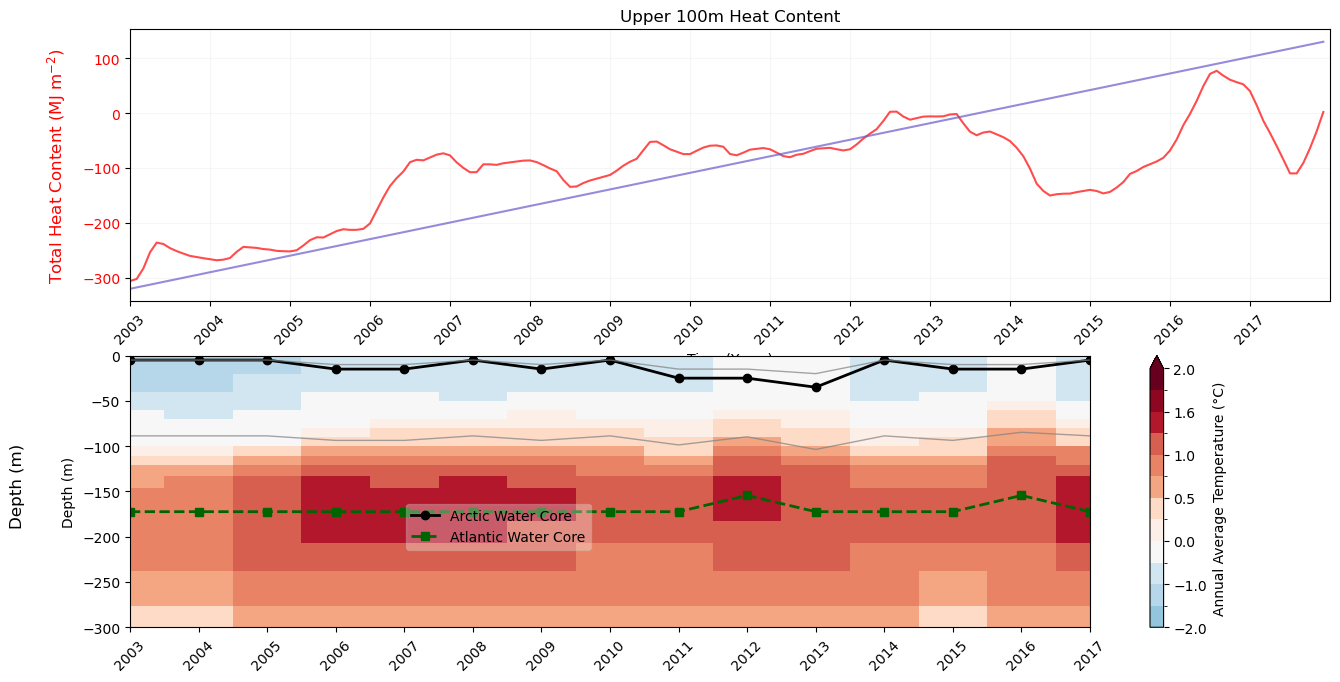

In [203]:
# plot the time series and the other mask

fig = plt.figure(figsize = (15,12))


# first subplot -- heat content timeseries
ax = plt.subplot(311)
window_size = 12
# Apply rolling mean
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax.plot(x_lind, y_lind-250, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax.set_ylabel(r"Total Heat Content (MJ m$^{-2}$)", color="red", fontsize=12, labelpad=10)
ax.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax.set_xlabel("Time (Years)")
ax.set_title("Upper 100m Heat Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.set_xlim(0, 15*12)
ax.grid(alpha=0.1)


# second subplot -- temperature at depth
ax = plt.subplot(312)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
# ax.set_title("Lind region T Profile, Annual Average")
cbar = plt.colorbar(cb,extend="max")
cbar.set_label("Annual Average Temperature (°C)")

xtick_positions = np.arange(0.5, 15.5, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
# ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)
# add the lines
# Overlay lines for key temperature depths
ax.plot(np.arange(0.5,15.5), min_temp_depths, color='black', marker='o', linestyle='-', label="Arctic Water Core",markersize=6,linewidth=2)
ax.plot(np.arange(0.5,15.5), max_temp_depths, color='darkgreen', marker='s', linestyle='--', label="Atlantic Water Core",markersize=6,linewidth=2)

# plot the midpoint lines
ax.plot(np.arange(0.5,15.5), mid_ArW_AW, color='gray', alpha=0.7, linestyle='-',linewidth=1)
ax.plot(np.arange(0.5,15.5), mid_surf_ArW, color='gray', alpha=0.7, linestyle='-',linewidth=1)

plt.xlim(0.5,14.5)
plt.ylabel("Depth (m)")

# ax.legend(loc="lower left", bbox_to_anchor=(0, 0.6), facecolor='white', framealpha=0.3)
ax.legend(loc="lower left", bbox_to_anchor=(0.28, 0.26), facecolor='white', framealpha=0.3)



# third subplot - thickness of ArW
mesh = np.zeros_like(thetaprofile_avg)

# plt.savefig("LindFig1c_v2.png",dpi=300)

In [197]:
# Fill between the two curves in the mesh
mesh = np.zeros_like()
x_vals = np.arange(0.5, 15.5)  # Same as in your plot

for i, x in enumerate(x_vals.astype(int)):  # Convert x to integer indices
    lower = int(mid_surf_ArW[i])  # Lower boundary
    upper = int(mid_ArW_AW[i])  # Upper boundary

    if 0 <= x < nx:  # Ensure within bounds
        mesh[lower:upper, x] = 1  # Fill values between curves

# Plot the mesh
fig, ax = plt.subplots()
ax.imshow(mesh, cmap="gray", origin="lower", extent=[0.5, 15.5, 0, ny])

# Overlay the two curves
ax.plot(x_vals, mid_ArW_AW, color='gray', alpha=0.7, linestyle='-', linewidth=1)
ax.plot(x_vals, mid_surf_ArW, color='gray', alpha=0.7, linestyle='-', linewidth=1)

NameError: name 'mesh' is not defined